In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
# Loading Dataset: Dataset 3 from research paper
df_test = pd.read_csv("E:/Mini_project_datasets/test_separated.csv")
df_train = pd.read_csv("E:/Mini_project_datasets/train_separated.csv")

In [3]:
# Exploratory Data Analysis on the Dataset
print("Test Data: \n", df_test.head(5))
print("Train Data: \n", df_train.head(5))


Test Data: 
    label                                            comment
0      0  This is a great book: I must preface this by s...
1      1  Huge Disappointment.: As a big time, long term...
2      0  Wayne is tight but cant hang with Turk.: This ...
3      0  Excellent: I read this book when I was in elem...
4      1  Not about Anusara: Although this book is toute...
Train Data: 
    label                                            comment
0      1  Very Mediocre: The fake velvet touch only enha...
1      0  Downton Abbey: I love it love it love it. I wo...
2      1  Roses Are Red: Disappointed in this one. They ...
3      1  Awful Experience: This Microsoft mouse stopped...
4      1  I must have seen a different movie: I have one...


In [4]:
# This function cleans up text so that only English characters are preserved
def processed_comments(df, text_column):
    not_alphanumeric = re.compile(r'[\W]')
    not_ascii = re.compile(r'[^a-z0-1\s]')

    processed_comments = []
    for comment in df[text_column]:
        lower = comment.lower()
        no_punctuation = not_alphanumeric.sub(r' ', lower)
        no_non_ascii = not_ascii.sub(r'', no_punctuation)
        processed_comments.append(no_non_ascii)

    df["processed_comments"] = processed_comments
    df.drop(columns=[text_column], inplace=True)  # Drop the previous text column
    return df

In [5]:
# Assuming the text column is named "text_column_name"
df_test = processed_comments(df_test, "comment")
df_train = processed_comments(df_train, "comment")

print("Shape of test dataset", df_test.shape)
print("Shape of train dataset", df_train.shape)

Shape of test dataset (80000, 2)
Shape of train dataset (320000, 2)


In [6]:
df_train["processed_comments"], val_text, df_train["label"], val_label = train_test_split(df_train["processed_comments"], df_train["label"], random_state=42, test_size=0.2)

In [7]:
# Drop rows with NaN values in the "processed_comments" column
df_train.dropna(subset=["processed_comments"], inplace=True)
df_test.dropna(subset=["processed_comments"], inplace=True)

In [8]:
df_train["processed_comments"].head(20)

# To get the count of comments from Label 0 and Label 1 from Training dataset
pd.DataFrame(df_train["label"]).value_counts()


label
1.0      128062
0.0      127938
dtype: int64

 Model Creation: Using Hybrid CNN-Bi-LSTM layers

In [9]:
max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train["processed_comments"])

X_train = tokenizer.texts_to_sequences(df_train["processed_comments"])
X_test = tokenizer.texts_to_sequences(df_test["processed_comments"])

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)


In [10]:
X_train = np.array(X_train)
print(X_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_train = np.array(df_train["label"])
print(y_train.shape)
y_test = np.array(df_test["label"])
print(y_test.shape)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

print(type(X_train[0]))
print(type(X_test[0]))
print(type(y_train[0]))
print(type(y_test[0]))

(256000, 100)
(80000, 100)
(256000,)
(80000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
<class 'numpy.int32'>


In [12]:
# Define CNN-Bi-LSTM Model
# Model Creation: Using Hybrid CNN-Bi-LSTM layers
def create_hybrid_model(optimizer, activation_function, lstm_layers, cnn_layers):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
    model.add(Conv1D(2048, 5, activation='relu'))  # Additional CNN layers
    model.add(MaxPooling1D(pool_size=2))
    for _ in range(lstm_layers):
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    model.add(Dense(1, activation=activation_function))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define different configurations
configurations = [
    {"optimizer": Adam(learning_rate=0.001), "activation_function": 'relu', "lstm_layers": 2, "cnn_layers": 2},  # Adjusted hyperparameters
]

results = []

for config in configurations:
    model = create_hybrid_model(config["optimizer"], config["activation_function"], config["lstm_layers"], config["cnn_layers"])
    model.fit(X_train, y_train, epochs=4, batch_size=2048, verbose=1)  # Adjusted batch size
    loss, accuracy = model.evaluate(X_test, y_test)
    results.append({"config": config, "loss": loss, "accuracy": accuracy})


Epoch 1/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 2032s 16s/step - accuracy: 0.5533 - loss: 2.3165
Epoch 2/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 1875s 15s/step - accuracy: 0.7938 - loss: 0.4657
Epoch 3/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 1851s 15s/step - accuracy: 0.8432 - loss: 0.3944
Epoch 4/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 1841s 15s/step - accuracy: 0.8116 - loss: 0.4332
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 229s 91ms/step - accuracy: 0.8462 - loss: 0.4637


Configuration: Optimizer=<keras.src.optimizers.adam.Adam object at 0x00000204B74F9B10>, Activation=relu, LSTM Layers=2
Test Loss: 0.4635370075702667, Test Accuracy: 0.8459749817848206

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 200s 80ms/step
Confusion Matrix:


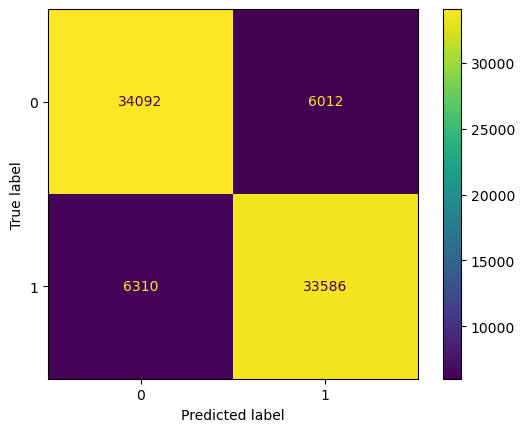

In [13]:
for result in results:
    config = result["config"]
    loss = result["loss"]
    accuracy = result["accuracy"]
    print(f"Configuration: Optimizer={config['optimizer']}, Activation={config['activation_function']}, LSTM Layers={config['lstm_layers']}")
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}\n")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [14]:

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     40104
           1       0.85      0.84      0.84     39896

    accuracy                           0.85     80000
   macro avg       0.85      0.85      0.85     80000
weighted avg       0.85      0.85      0.85     80000

